In [1]:
#!pip uninstall tensorflow
#!pip uninstall keras
#!pip install tensorflow
#!pip install keras

In [1]:
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import skimage
from skimage import io
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import *
import tensorflow.keras.backend as K

import os
import lmdb 
from struct import pack
from struct import unpack
import cv2
# import keras.backend.tensorflow_backend as KTF
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
NUM_ATTRIBUTES=5
NUM_IMAGE=202599
NUM_TRAIN=15000 #在这里改用的数据数量
BATCH_SIZE=128
NUM_TEST=10

## Get Labels

In [4]:
Attr_file = '/content/drive/MyDrive/DL/att_list.txt' 
labels = np.ones([1,NUM_ATTRIBUTES],dtype=np.int)
tag_name = []
with open(Attr_file, "r") as Attr_file:
    Attr_info = Attr_file.readlines()
    tag_name = Attr_info[0]
    Attr_info = Attr_info[1:NUM_TRAIN+1] #get 50000lines
    #begin to read the labels 
    for line in Attr_info:
        info = line.split()
        index = int(info[0])
        attributes = info[1:NUM_ATTRIBUTES+1]
        attributes = np.array(attributes,dtype=np.int)
        attributes = np.add(attributes,labels[0,:])/2
        attributes = np.reshape(attributes, (1, NUM_ATTRIBUTES)) 
        labels = np.concatenate((labels,attributes),axis=0)
        if (index == 50000):
            break
            
    #to delete the first empty lines
    labels=np.delete(labels,0, 0)
    print (np.shape(labels))

<ipython-input-4-e4567693a70b>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.ones([1,NUM_ATTRIBUTES],dtype=np.int)
<ipython-input-4-e4567693a70b>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in Num

(15000, 5)


In [5]:
sumA = np.zeros(5)
for i in range(0,15000):
  sumA = sumA + labels[i]
print(sumA)

[ 6763.  6332. 12482.  4777. 11669.]


## Get Images

In [6]:
im_size = (96, 96)
#the new dataset has already been shaped
imageDB_path = '/content/drive/MyDrive/DL/CeleADB/reshaped_data' #换db改路径
env_db = lmdb.Environment(imageDB_path)
X=np.zeros((NUM_TRAIN,im_size[0],im_size[1],3),dtype=np.float16)#这句可以改，分辨率调低一点
txn = env_db.begin() 
for key, value in txn.cursor():
    img = cv2.imdecode(np.frombuffer(value, np.uint8), cv2.IMREAD_UNCHANGED)
    img = img/255.
    #img = skimage.transform.resize(img, im_size, order=3)#这句对应上面可以降分辨率
    value = unpack('i',key)[0] - 1
    X[value,:,:,:] = img

txn.commit()
env_db.close()

<class 'numpy.ndarray'>
(96, 96, 3)
High_Cheekbones Male No_Beard Wavy_Hair Young

[0. 0. 1. 1. 1.]


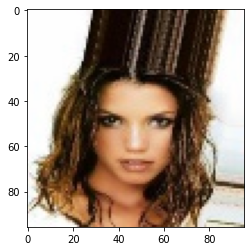

In [7]:
index = 1004
print(type(X[index]))
print(X[index].shape)
a = np.array(X[index],dtype=np.float32)
plt.imshow(a)
print(tag_name)
print(labels[index])

## Train

In [8]:
# Calculates the precision
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Calculates the recall
def recall(y_true, y_pred):    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall 

def label_acc(y_true, y_pred):
    # Calculates the precision
    #true_positives = tf.convert_to_tensor(y_true, dtype = tf.float32)
    true_positives = y_true
    predicted_positives = K.round(K.clip(y_pred, 0, 1))
    all = K.sum(K.round(K.clip(y_true + 100, 0, 1)))
    precision = (all - K.sum(K.abs(true_positives - predicted_positives)))/all
    return precision

In [9]:
#split train test data  
X_train,X_val,Y_train,Y_val = train_test_split(X, labels, test_size=0.01, random_state=2018)
train_datagen=ImageDataGenerator()
val_datagen = ImageDataGenerator() 
        
train_generator = train_datagen.flow(X_train,Y_train,batch_size=BATCH_SIZE,shuffle=False) 
val_generator = val_datagen.flow(X_val,Y_val,batch_size=BATCH_SIZE,shuffle=False)


In [10]:
BS = 64
#base_model = InceptionV3(weights='imagenet',include_top=False)
base_model = VGG16(include_top = False, weights = 'imagenet')
    
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024,activation='relu')(x)
predictions = Dense(NUM_ATTRIBUTES,activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions) 
#model.summary()
#model=load_model('project_model.h5')

In [11]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy',label_acc])
history_ft = model.fit(train_datagen.flow(X_train, Y_train, BS),
                       steps_per_epoch=len(X_train)//BS,
                       epochs=8,
                       validation_data=val_datagen.flow(X_val, Y_val, BS),
                       validation_steps=len(X_val)//BS,
                       verbose=1)

Epoch 1/8
232/232 [==============================] - 52s 176ms/step - loss: 0.3778 - accuracy: 0.4516 - label_acc: 0.8216 - val_loss: 0.2975 - val_accuracy: 0.3750 - val_label_acc: 0.8687
Epoch 2/8
232/232 [==============================] - 39s 169ms/step - loss: 0.2643 - accuracy: 0.4976 - label_acc: 0.8863 - val_loss: 0.3313 - val_accuracy: 0.3906 - val_label_acc: 0.8609
Epoch 3/8
232/232 [==============================] - 40s 170ms/step - loss: 0.2389 - accuracy: 0.5007 - label_acc: 0.8984 - val_loss: 0.2608 - val_accuracy: 0.4297 - val_label_acc: 0.8766
Epoch 4/8
232/232 [==============================] - 39s 170ms/step - loss: 0.2169 - accuracy: 0.5016 - label_acc: 0.9100 - val_loss: 0.2463 - val_accuracy: 0.4141 - val_label_acc: 0.8953
Epoch 5/8
232/232 [==============================] - 39s 170ms/step - loss: 0.1917 - accuracy: 0.5142 - label_acc: 0.9194 - val_loss: 0.2813 - val_accuracy: 0.4766 - val_label_acc: 0.8891
Epoch 6/8
232/232 [==============================] - 39s 170

In [15]:
h = history_ft

In [28]:
model.save('/content/drive/MyDrive/DL/vgg_054_089.h5')

In [31]:
model=load_model('/content/drive/MyDrive/DL/vgg_model_newpre.h5', compile = False)

In [13]:
XY = val_generator.next()

In [14]:
print(XY[0].shape)
print(XY[1].shape)

(128, 96, 96, 3)
(128, 5)


In [56]:
XY_pred = np.where(model(XY[0]) > 0.5, 1., 0.)

The attributes are High_Cheekbones Male No_Beard Wavy_Hair Young



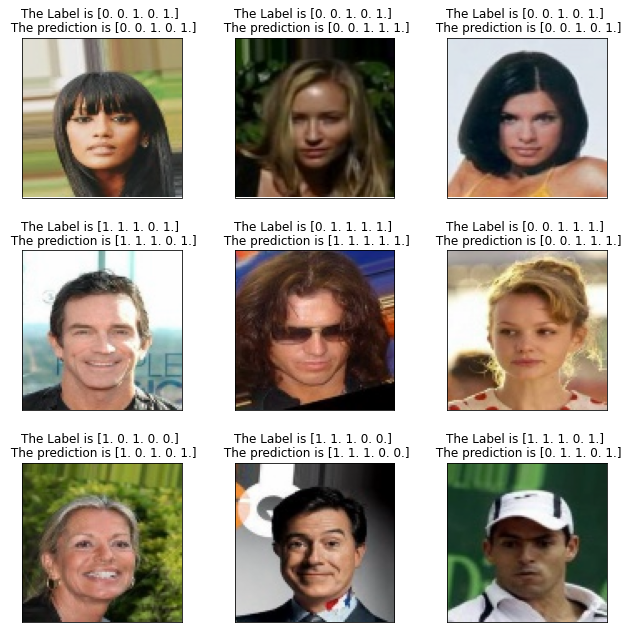

In [57]:
num_row = 3
num_col = 3# plot images
num = num_col*num_row
np.random.seed(45)
randIdx = [np.random.randint(128) for i in range(num)]
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
print(f"The attributes are {tag_name}")
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(XY[0][randIdx[i]])
    ax.set_title(f"The Label is {XY[1][randIdx[i]]} \n The prediction is {XY_pred[randIdx[i]]}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()


(0.0, 0.8)

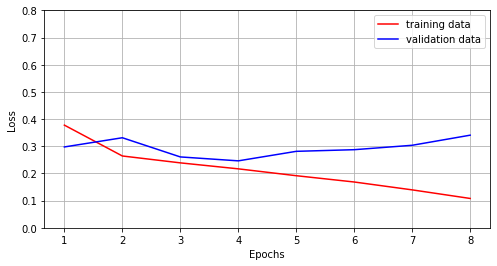

In [58]:
#epoch_x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
#temp1 = h.history['loss']+history_ft.history['loss']
#temp2 = h.history['val_loss']+history_ft.history['val_loss']
epoch_x = [1,2,3,4,5,6,7,8]
temp1 = history_ft.history['loss']
temp2 = history_ft.history['val_loss']
plt.figure(figsize = (8,4))
plt.grid()
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.plot(epoch_x, temp1, color = 'red', label = 'training data')
plt.plot(epoch_x, temp2, color = 'blue', label = 'validation data')
plt.legend()
plt.ylim(0, 0.8)

(0.0, 0.6)

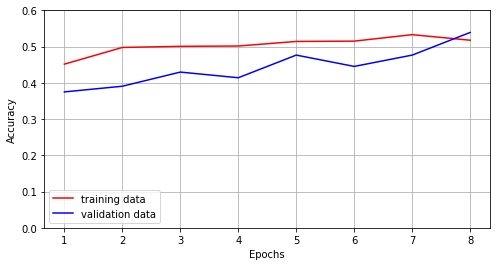

In [59]:
#temp1 = h.history['accuracy']+history_ft.history['accuracy']
#temp2 = h.history['val_accuracy']+history_ft.history['val_accuracy']
temp1 = history_ft.history['accuracy']
temp2 = history_ft.history['val_accuracy']
plt.figure(figsize = (8,4))
plt.grid()
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.plot(epoch_x, temp1, color = 'red', label = 'training data')
plt.plot(epoch_x, temp2, color = 'blue', label = 'validation data')
plt.legend()
plt.ylim(0, 0.6)

(0.5, 1.0)

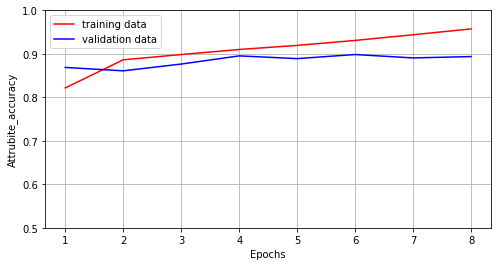

In [60]:
#temp1 = h.history['label_acc']+history_ft.history['label_acc']
#temp2 = h.history['val_label_acc']+history_ft.history['val_label_acc']
temp1 = history_ft.history['label_acc']
temp2 = history_ft.history['val_label_acc']
plt.figure(figsize = (8,4))
plt.grid()
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Attrubite_accuracy', fontsize = 10)
plt.plot(epoch_x, temp1, color = 'red', label = 'training data')
plt.plot(epoch_x, temp2, color = 'blue', label = 'validation data')
plt.legend()
plt.ylim(0.5, 1)